In [43]:
def featurize(dataloader, model, flag='ft'):
    collect = []
    for batch in tqdm(dataloader, desc=f"Featurizing {flag}"):
        model.eval()
        batch = tuple(t.to(args['device']) for t in batch)

        with torch.no_grad():
            inputs = {
                "input_ids": batch[0],
                "attention_mask": batch[1],
                "labels": batch[3],
            }
            if args['model_type'] != "distilbert":
                inputs["token_type_ids"] = (
                    batch[2] if args['model_type'] in ["bert", "xlnet"] else None
                )  # XLM, DistilBERT and RoBERTa don't use segment_ids

            outputs = model(**inputs)
            if args['model_type'] != 'tnlr':
                layer_outputs = outputs[2] #loss, logits, hidden, attn
            else:
                layer_outputs = outputs[2][0] #loss, logits, hidden  
        layer_outputs = torch.stack(layer_outputs) #[layer, batch, seq, d]
        cls_layer_outputs = torch.tensor(layer_outputs[:, :, 0, :]) #[layer, batch, d]
        collect.append(cls_layer_outputs)

    feature = torch.cat(collect, dim=1) #[layer, N, d]
    return feature

In [186]:
import argparse
import numpy as np
import os
import pandas as pd
import scipy as sp
import sys
import torch
import torch.nn.functional as F
import warnings
import random
import json
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, paired_distances
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.stats import spearmanr
import collections
import seaborn as sns

warnings.filterwarnings("ignore")

base_dir = os.path.split(os.getcwd())[0]
sys.path.append(base_dir)
sys.path.append(f"{base_dir}/turing/examples-raw/gluesst_finetune/")
sys.path.append(f"{base_dir}/turing/src/")

from argparse import Namespace
from methods.bag_of_ngrams.processing import cleanReports, cleanSplit, stripChars
from methods.interpretations.utils import compute_input_type_attention
from methods.interpretations.integrated_gradients.utils import forward_with_softmax, summarize_attributions
from pyfunctions.general import extractListFromDic, readJson
from pyfunctions.pathology import extract_synoptic, fixLabelProstateGleason, fixProstateLabels, fixLabel, exclude_labels
from pyfunctions.feature_anaysis_utils import center, calculate_geometry, compute_RSA, get_projection, low_rank_approx, rank_1_approx, get_acc, get_stimuli
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import AutoTokenizer, AutoModel
from transformers import BertTokenizer, BertForSequenceClassification
from turing.pathology.path_utils import evaluate, extract_features, load_tnlr_base, load_tnlr_tokenizer, path_dataset

args = {
    'model_type': 'clinical_biobert', # tnlr, bert, pubmed_bert, biobert, clinical_biobert
    'task_name': 'sst-2',
    'do_train': False,
    'do_eval': True,
    'evaluate_during_training': True,
    'max_seq_length': 512,
    'do_lower_case': True,
    'per_gpu_train_batch_size': 8,
    'per_gpu_eval_batch_size': 8,
    'gradient_accumulation_steps': 1,
    'learning_rate': 7e-6,
    'weight_decay': 0.0,
    'adam_epsilon': 1e-8,
    'max_grad_norm': 1,
    'num_train_epochs': 3.0,
    'max_steps': -1,
    'warmup_ratio': 0.2,
    'logging_steps': 50,
    'eval_all_checkpoints': True,
    'no_cuda': False,
    'seed': 42,
    'metric_for_choose_best_checkpoint': None,
    'fp16': False,
    'fp16_opt_level': 'O1',
    'local_rank': -1,
    'num_train_epochs': 25, 
    'n_gpu': 1,
    'device': 'cuda',
    'run': 0
}

kwargs = Namespace(**args)

In [187]:
if args['model_type'] == 'bert':
    bert_path = 'bert-base-uncased'
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
elif args['model_type'] == 'pubmed_bert':
    bert_path = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"
    tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract")
elif args['model_type'] == 'biobert':
    bert_path = "dmis-lab/biobert-v1.1"
    tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
elif args['model_type'] == 'clinical_biobert':
    bert_path = "emilyalsentzer/Bio_ClinicalBERT"
    tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
elif args['model_type'] == 'tnlr':
    vocab_file = f'{base_dir}/turing/src/tnlr/tokenizer/tnlr-uncased-vocab.txt'
    tokenizer = load_tnlr_tokenizer(vocab_file)

In [188]:
# Read in data
field = 'SeminalVesicleNone' # out of PrimaryGleason, SecondaryGleason', 'MarginStatusNone', 'SeminalVesicleNone'
path = f"../data/prostate.json"
data = readJson(path)

# Clean reports
data = cleanSplit(data, stripChars)
data['dev_test'] = cleanReports(data['dev_test'], stripChars)
data = fixLabel(data)

train_documents = [extract_synoptic(patient['document'].lower(), tokenizer) for patient in data['train']]
train_labels = [patient['labels'][field] for patient in data['train']]

val_documents = [extract_synoptic(patient['document'].lower(), tokenizer) for patient in data['val']]
val_labels = [patient['labels'][field] for patient in data['val']]

test_documents = [extract_synoptic(patient['document'].lower(), tokenizer) for patient in data['test']]
test_labels = [patient['labels'][field] for patient in data['test']]

if field in ['PrimaryGleason', 'SecondaryGleason']:
    # Exclude '2' and 'null'
    train_documents, train_labels = exclude_labels(train_documents, train_labels)
    val_documents, val_labels = exclude_labels(val_documents, val_labels)
    test_documents, test_labels = exclude_labels(test_documents, test_labels)

2066 517 324


In [189]:
# Create datasets
le = preprocessing.LabelEncoder()
le.fit(train_labels)

# Map raw label to processed label
le_dict = dict(zip(le.classes_, le.transform(le.classes_)))
le_dict = {str(key):le_dict[key] for key in le_dict}

for label in val_labels + test_labels:
    if str(label) not in le_dict:
        le_dict[str(label)] = len(le_dict)
        
train_labels = [le_dict[str(label)] for label in train_labels]
val_labels = [le_dict[str(label)] for label in val_labels]
test_labels = [le_dict[str(label)] for label in test_labels]
        
# Map processed label back to raw label
inv_le_dict = {v: k for k, v in le_dict.items()}

In [190]:
documents_full = train_documents + val_documents + test_documents
labels_full = train_labels + val_labels + test_labels

p_test = len(test_labels)/len(labels_full)
p_val = len(val_labels)/(len(train_labels) + len(val_labels))

In [191]:
sample_flag = 'random'
geo_flag = 'tri'
dis_flag = 'euc'
results = {}
for i in range(3):
    #load fine_tune model
    ft_model_path = f"{base_dir}/output/fine_tuning/{args['model_type']}_{i}/{field}"
    ft_checkpoint_file = f"{ft_model_path}/save_output"
    ft_config_file = f"{ft_model_path}/save_output/config.json"

    #specify snapshot
    #ft_checkpoint_file = f"{ft_model_path}/epoch-10"
    #ft_config_file = f"{ft_model_path}/epoch-10/config.json"

    if args['model_type'] != 'tnlr':
        ft_model = BertForSequenceClassification.from_pretrained(ft_checkpoint_file, num_labels=len(le_dict), output_hidden_states=True)
    else:
        ft_model = load_tnlr_base(ft_checkpoint_file, ft_config_file, model_type='tnlrv3_classification', num_labels=len(le_dict))
        ft_model.config.update({'output_hidden_states': True})

    #load untuned model (frozen up to 12)
    un_model_path = f"{base_dir}/output/frozen/{args['model_type']}_{i}_12/{field}"
    un_checkpoint_file = f"{un_model_path}/save_output"
    un_config_file = f"{un_model_path}/save_output/config.json"

    if args['model_type'] != 'tnlr':
        un_model = BertForSequenceClassification.from_pretrained(un_checkpoint_file, num_labels=len(le_dict), output_hidden_states=True)
    else:
        un_model = load_tnlr_base(un_checkpoint_file, un_config_file, model_type='tnlrv3_classification', num_labels=len(le_dict))
        un_model.config.update({'output_hidden_states': True})
        

    #sampling
    train_docs, test_docs, train_labels, test_labels = train_test_split(documents_full, 
                                                                        labels_full, 
                                                                        test_size= p_test,
                                                                        random_state=i)

    train_docs, val_docs, train_labels, val_labels = train_test_split(train_docs, 
                                                                      train_labels, 
                                                                      test_size= p_val,
                                                                      random_state=i)

    # obtain embeddings of stimuli
    N = 1000
    corpus = train_docs
    labels = train_labels

    samples, labels = get_stimuli(N, corpus, labels, flag=sample_flag)
    sample1, sample2 = None, None
    label1, label2 = None, None
    if len(samples) > 1:
        sample1, sample2 = samples[0], samples[1]
        label1, label2 = labels[0], labels[1]
    else:
        sample1 = samples[0]
        label1 = labels[0]

    ft_layer_cls_logits1, un_layer_cls_logits1 = None, None
    ft_layer_cls_logits2, un_layer_cls_logits2 = None, None
        
    if sample1:
        ft_dataset = path_dataset(sample1, label1, ft_model, tokenizer)
        ft_dataloader = DataLoader(ft_dataset, batch_size=kwargs.per_gpu_train_batch_size)
        
        un_dataset = path_dataset(sample1, label1, un_model, tokenizer)
        un_dataloader = DataLoader(un_dataset, batch_size=kwargs.per_gpu_train_batch_size)
        with torch.cuda.device(1):
            ft_model = ft_model.to(args['device'])
            un_model = un_model.to(args['device'])
            ft_layer_cls_logits1 = featurize(ft_dataloader, ft_model, flag='ft')
            un_layer_cls_logits1 = featurize(un_dataloader, un_model, flag='un')

    
    if sample2:
        ft_dataset = path_dataset(sample2, label2, ft_model, tokenizer)
        ft_dataloader = DataLoader(ft_dataset, batch_size=kwargs.per_gpu_train_batch_size)
        
        un_dataset = path_dataset(sample2, label2, un_model, tokenizer)
        un_dataloader = DataLoader(un_dataset, batch_size=kwargs.per_gpu_train_batch_size)
        
        ft_model = ft_model.cuda()
        un_model = un_model.cuda()
        ft_layer_cls_logits2 = featurize(ft_dataloader, ft_model, flag='ft')
        un_layer_cls_logits2 = featurize(un_dataloader, un_model, flag='un')

    layer_sims, layer_affns, label_indices = compute_RSA(13, sample_flag, geo_flag, dis_flag,
                            ft_layer_cls_logits1, un_layer_cls_logits1, ft_layer_cls_logits2, un_layer_cls_logits2)
    results[i] = layer_sims
    
    del ft_model
    del un_model
    del ft_dataset
    del ft_dataloader
    del un_dataset
    del un_dataloader

SeminalVesicleNone
1000 None


Featurizing ft: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [02:19<00:00,  1.11s/it]


torch.Size([13, 1000, 768])


Featurizing un: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [02:20<00:00,  1.13s/it]


torch.Size([13, 1000, 768])
{0: defaultdict(<class 'list'>, {0: [0.9999999999999999], 1: [0.9981620621759109], 2: [0.9818259007402541], 3: [0.9800903253240585], 4: [0.8322777514104625], 5: [0.836055363909104], 6: [0.7545821842270732], 7: [0.5595676129380435], 8: [0.45016337139390017], 9: [0.36043997211893214], 10: [0.18129692439811235], 11: [0.14539781058584916], 12: [0.1669569254354835]})}
1000 None


Featurizing ft: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [02:19<00:00,  1.11s/it]


torch.Size([13, 1000, 768])


Featurizing un: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [02:20<00:00,  1.12s/it]


torch.Size([13, 1000, 768])
{0: defaultdict(<class 'list'>, {0: [0.9999999999999999], 1: [0.9981620621759109], 2: [0.9818259007402541], 3: [0.9800903253240585], 4: [0.8322777514104625], 5: [0.836055363909104], 6: [0.7545821842270732], 7: [0.5595676129380435], 8: [0.45016337139390017], 9: [0.36043997211893214], 10: [0.18129692439811235], 11: [0.14539781058584916], 12: [0.1669569254354835]}), 1: defaultdict(<class 'list'>, {0: [nan], 1: [0.9966503507111183], 2: [0.974939528276595], 3: [0.9362395074943104], 4: [0.7922481339509497], 5: [0.8505241623302819], 6: [0.7839428128493445], 7: [0.7537924162820749], 8: [0.7230173408282711], 9: [0.6154786158379606], 10: [0.30554969561236006], 11: [0.3154553402416183], 12: [0.2943131127792429]})}
1000 None


Featurizing ft: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [02:15<00:00,  1.08s/it]


torch.Size([13, 1000, 768])


Featurizing un: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [02:20<00:00,  1.13s/it]


torch.Size([13, 1000, 768])
{0: defaultdict(<class 'list'>, {0: [0.9999999999999999], 1: [0.9981620621759109], 2: [0.9818259007402541], 3: [0.9800903253240585], 4: [0.8322777514104625], 5: [0.836055363909104], 6: [0.7545821842270732], 7: [0.5595676129380435], 8: [0.45016337139390017], 9: [0.36043997211893214], 10: [0.18129692439811235], 11: [0.14539781058584916], 12: [0.1669569254354835]}), 1: defaultdict(<class 'list'>, {0: [nan], 1: [0.9966503507111183], 2: [0.974939528276595], 3: [0.9362395074943104], 4: [0.7922481339509497], 5: [0.8505241623302819], 6: [0.7839428128493445], 7: [0.7537924162820749], 8: [0.7230173408282711], 9: [0.6154786158379606], 10: [0.30554969561236006], 11: [0.3154553402416183], 12: [0.2943131127792429]}), 2: defaultdict(<class 'list'>, {0: [nan], 1: [0.9950768842113835], 2: [0.9652537833230455], 3: [0.9627420527365239], 4: [0.9645382657902049], 5: [0.9475589973486391], 6: [0.880582850671685], 7: [0.7930981029942566], 8: [0.4791259788215927], 9: [0.438917640303

In [192]:
sv_rsa = {}
sv_rsa[args['model_type']] = results
sv_rsa.keys()

dict_keys(['bert', 'tnlr', 'pubmed_bert', 'biobert', 'clinical_biobert'])

In [193]:
save_path = f"{base_dir}/output/rsa"
os.makedirs(save_path, exist_ok=True)

# save
with open(os.path.join(save_path, "sv_rsa.pkl"), 'wb') as handle:
    pickle.dump(sv_rsa, handle)

In [194]:
# open
with open(os.path.join(save_path, "sv_rsa.pkl"), 'rb') as handle:
    test = pickle.load(handle)

In [195]:
models = ['bert', 'tnlr', 'pubmed_bert', 'biobert', 'clinical_biobert']
dfs = {}

for m in models:
    results_dt = pd.DataFrame(columns=['layer', 'corr'])
    i = 0
    for l in range(1, 13):
        for run in range(3):
            row = pd.Series({'layer': l, 'corr': test[m][run][l][0]}, name=i)
            results_dt = results_dt.append(row)
            i+=1
    dfs[m] = results_dt

In [196]:
dfs['bert']['model'] = 'BERT'
dfs['tnlr']['model'] = 'TNLR'
dfs['pubmed_bert']['model'] = 'PubMed BERT'
dfs['biobert']['model'] = 'BioBERT'
dfs['clinical_biobert']['model'] = 'Clinical BioBERT'

data = pd.concat([dfs['bert'], dfs['tnlr'], dfs['pubmed_bert'], dfs['biobert'], dfs['clinical_biobert']])

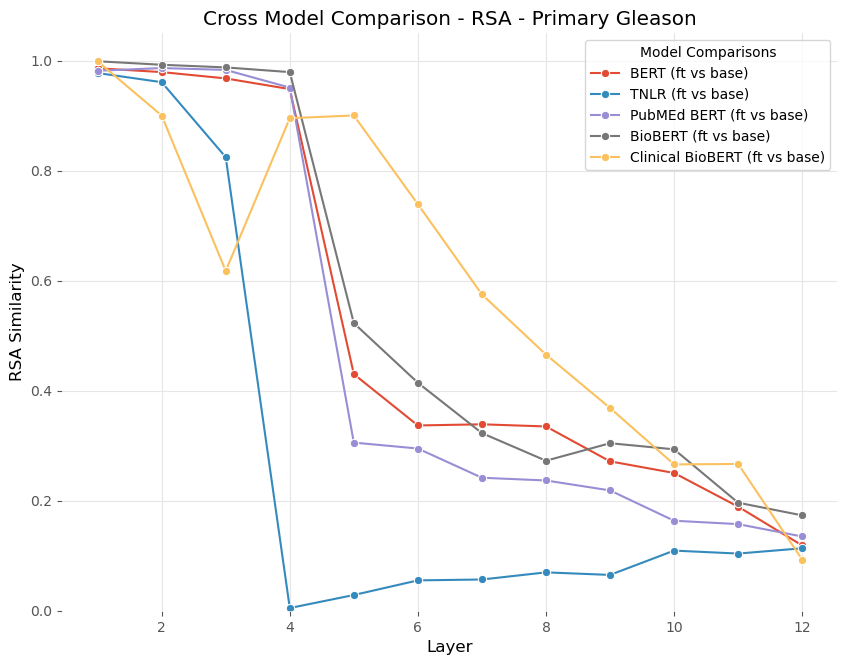

In [112]:
plt.style.use(os.path.join(f"{base_dir}/theme_bw.mplstyle"))

plt.figure(figsize=(10, 7.5))

# Remove the plot frame lines. They are unnecessary chartjunk.  
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)   
ax.spines["right"].set_visible(False)    

# Ensure that the axis ticks only show up on the bottom and left of the plot.  
# Ticks on the right and top of the plot are generally unnecessary chartjunk.  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()
ax.set_ylim(bottom = 0, top=1.05)

plt.xlabel('Layer') 
plt.ylabel('RSA Similarity') 

sns.lineplot(x = "layer", y = "corr", data=data, hue='model', marker='o', ci=None)#, palette=color_scheme)

plt.title("Cross Model Comparison - RSA - Primary Gleason")
plt.legend(title='Model Comparisons', labels=['BERT (ft vs base)', 'TNLR (ft vs base)',
                                              'PubMEd BERT (ft vs base)', 'BioBERT (ft vs base)',
                                              'Clinical BioBERT (ft vs base)'])

plt.show()

#plt.savefig('micro.png', dpi=300)